# Installing / Importing Libraries

In [90]:
import pandas as pd
from pandas import to_datetime
import numpy as np
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import HoltWintersResults
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
import time
from numpy import array
import string

In [91]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data

In [92]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [93]:
Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)
Daily_data

,Inquiries_NonStat
date,
2017-01-01,7574.0
2017-01-02,13189.0
2017-01-03,24678.0
2017-01-04,23380.0
2017-01-05,22809.0
...,...
2022-09-26,13039.0
2022-09-27,11598.0
2022-09-28,11886.0


In [94]:
Daily_data.isna().any()

Inquiries_NonStat    False
dtype: bool

In [95]:
Daily_data.describe()

,Inquiries_NonStat
count,2099.000000
mean,14240.924250
std,5809.277724
min,406.000000
25%,9739.500000
50%,13864.000000
75%,19310.000000
max,30619.000000


<AxesSubplot: xlabel='date'>

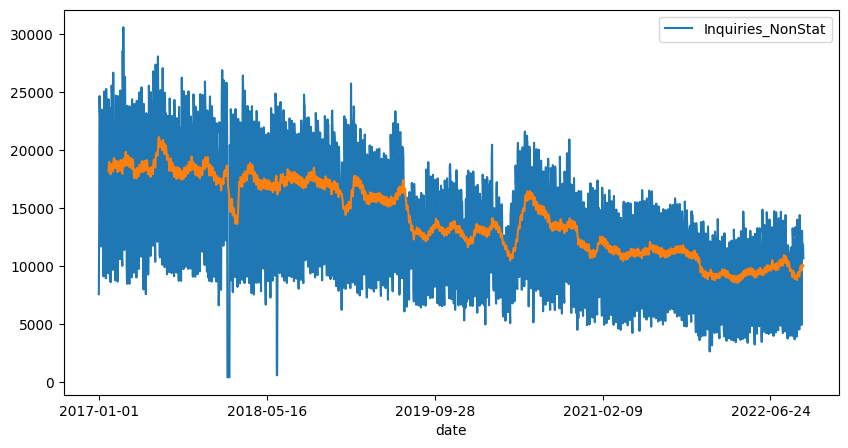

In [96]:
Daily_data.drop(Daily_data.columns.difference(['Inquiries_NonStat']),1, inplace=True)
Daily_data.plot()
Daily_data.rolling(window=30).mean()['Inquiries_NonStat'].plot()

In [97]:
Daily_data = Daily_data.reset_index('date')
Daily_data['date'] = pd.to_datetime(Daily_data['date'])
Daily_data = Daily_data.set_index('date')

# Splitting the data into 80:20 ratio

In [98]:
train_df = Daily_data.iloc[:1680]
test_df  = Daily_data.iloc[1679:]

In [99]:
train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

In [100]:
#%pip install tabulate

In [101]:
from tabulate import tabulate

# Create an empty table
table = []

# Add the column names
table.append(["Trend", "DampedT", "Seasonality", "SPeriods", "RemoveBias","LeadTime", "Steps", "RMSE","AIC"])

### Holt-Winters Model with different lead times & multisteps

## Lead time = 0 & 7-step ahead

In [102]:
data = train_df.values

y_prediction = []
filterwarnings("ignore")
ES_model = ExponentialSmoothing(data, trend='mul', seasonal= 'mul', seasonal_periods=7)
ES_results = ES_model.fit()
y = ES_results.predict(0,6)
print(y)

[ 9856.55785968 20953.55324996 20616.00733475 20222.54644478
 20856.58023923 18612.54738411 10668.4691788 ]


In [103]:

print(ES_results.summary().tables[0])

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1680
Model:             ExponentialSmoothing   SSE                     8626453418.343
Optimized:                         True   AIC                          25980.604
Trend:                   Multiplicative   BIC                          26040.296
Seasonal:                Multiplicative   AICC                         25980.823
Seasonal Periods:                     7   Date:                 Wed, 04 Jan 2023
Box-Cox:                          False   Time:                         17:43:30
Box-Cox Coeff.:                    None                                         


In [104]:
test_ = pd.DataFrame(test_df[:7])
test_['predictions'] = y#_prediction
test_ = test_.dropna()
test_.isna().any()
test_

,Inquiries_NonStat,predictions
date,,
2021-08-07,5879.0,9856.557860
2021-08-08,4960.0,20953.553250
2021-08-09,14917.0,20616.007335
2021-08-10,13359.0,20222.546445
2021-08-11,13114.0,20856.580239
2021-08-12,12899.0,18612.547384
2021-08-13,11992.0,10668.469179


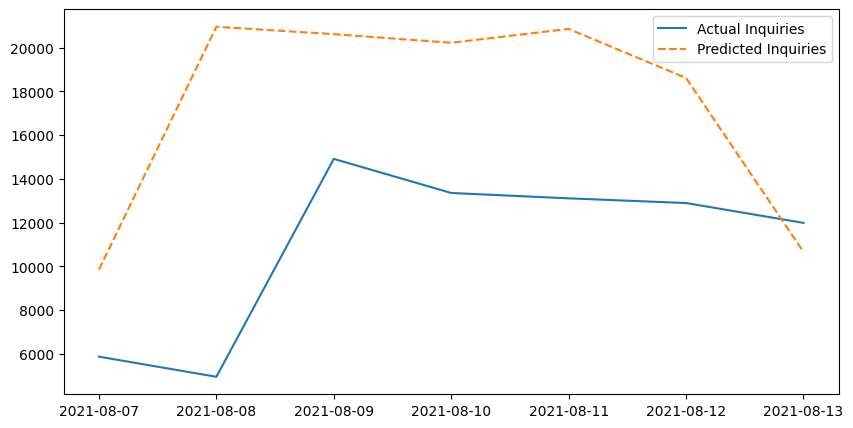

In [105]:
plt.plot(test_.loc['2021-08-07':'2021-8-13']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_.loc['2021-08-07':'2021-8-13'].predictions, '--', label = 'Predicted Inquiries')
plt.legend()

In [106]:
test_

,Inquiries_NonStat,predictions
date,,
2021-08-07,5879.0,9856.557860
2021-08-08,4960.0,20953.553250
2021-08-09,14917.0,20616.007335
2021-08-10,13359.0,20222.546445
2021-08-11,13114.0,20856.580239
2021-08-12,12899.0,18612.547384
2021-08-13,11992.0,10668.469179


# Evaluating Prediction

In [107]:
#trend='mul', seasonal= 'mul', seasonal_periods=7) --> RMSE:7978.055
error = np.round(np.sqrt(mean_squared_error(test_.Inquiries_NonStat,test_.predictions)), decimals = 3)
print ('Test RMSE for Triple Exponential Smoothing with Walk-Forward Validation: ', error)
print(ES_results.summary().tables[0].data[2][2:])

Test RMSE for Triple Exponential Smoothing with Walk-Forward Validation:  7978.055
['  AIC                ', '25980.604']


<AxesSubplot: xlabel='date'>

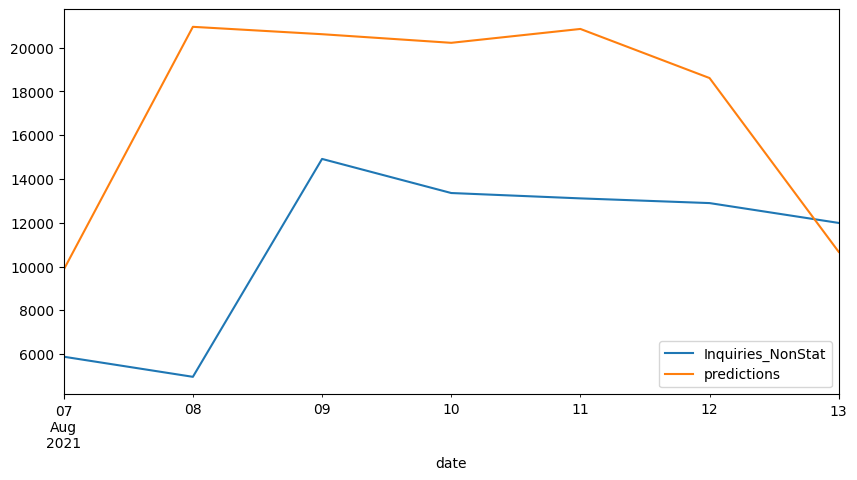

In [108]:
test_.plot()

# Hyperparameter Tuning

## Lead time = 0 & 30days-step ahead

In [109]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	#history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(0,6)
	
	aic_score = float(model_fit.summary().tables[0].data[2][3])
	return yhat, aic_score

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# fit model and make forecast for history
	yhat, aic_score = exp_smoothing_forecast(train, cfg)
	# store forecast in list of predictions
	predictions = yhat
	# add actual observation to history for the next loop
	
	# estimate prediction error
	error = measure_rmse(test[:7], predictions)


	return error, aic_score

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	aic_score = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result, aic_score = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result, aic_score = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f %.3f' % (key, result, aic_score))
	return (key, result, aic_score)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul']
	p_params = [ 7]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error, aic in scores[:3]:
		print(cfg, 'RMSE: ',error, 'AIC: ', aic)
	
	# Adding top scores to table
	for cfg, error, aic in scores[:1]:
		# Create a translation table that will remove all punctuations
		cfg = cfg.translate(cfg.maketrans("", "", string.punctuation))
		table.append([cfg.split()[0], cfg.split()[1], cfg.split()[2], cfg.split()[3], cfg.split()[4], 0, 7, error, aic])

	

 > Model[['add', True, 'add', 7, True]] 6034.474 6743.610
 > Model[['add', True, 'add', 7, False]] 6034.312 6743.610
 > Model[['add', True, 'mul', 7, True]] 5794.016 6714.999
 > Model[['add', True, 'mul', 7, False]] 5796.571 6714.999
 > Model[['add', False, 'add', 7, True]] 6037.679 6742.084
 > Model[['add', False, 'add', 7, False]] 6035.709 6742.084
 > Model[['add', False, 'mul', 7, True]] 5790.238 6713.804
 > Model[['add', False, 'mul', 7, False]] 5797.661 6713.804
 > Model[['mul', True, 'add', 7, True]] 6010.905 6743.487
 > Model[['mul', True, 'add', 7, False]] 6015.859 6743.487
 > Model[['mul', True, 'mul', 7, True]] 5791.446 6714.719
 > Model[['mul', True, 'mul', 7, False]] 5790.933 6714.719
 > Model[['mul', False, 'add', 7, True]] 6036.118 6740.936
 > Model[['mul', False, 'add', 7, False]] 6034.133 6740.936
 > Model[['mul', False, 'mul', 7, True]] 5789.136 6712.287
 > Model[['mul', False, 'mul', 7, False]] 5795.962 6712.287
 > Model[[None, False, 'add', 7, True]] 6025.985 6737.22

['mul', False, 'mul', 7, True] RMSE:  5789.136310492624 AIC:  6712.287
['add', False, 'mul', 7, True] RMSE:  5790.237537589243 AIC:  6713.804
['mul', True, 'mul', 7, False] RMSE:  5790.933054722083 AIC:  6714.719

## Lead time = 0 & 30days-step ahead

In [110]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	#history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(0,29)
	
	aic_score = float(model_fit.summary().tables[0].data[2][3])
	return yhat, aic_score

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# fit model and make forecast for history
	yhat, aic_score = exp_smoothing_forecast(train, cfg)
	# store forecast in list of predictions
	predictions = yhat
	# add actual observation to history for the next loop
	
	# estimate prediction error
	error = measure_rmse(test[:30], predictions)


	return error, aic_score

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	aic_score = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result, aic_score = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result, aic_score = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f %.3f' % (key, result, aic_score))
	return (key, result, aic_score)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul']
	p_params = [ 7]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error, aic in scores[:3]:
		print(cfg, 'RMSE: ',error, 'AIC: ', aic)
	
	# Adding top scores to table
	for cfg, error, aic in scores[:1]:
		# Create a translation table that will remove all punctuations
		cfg = cfg.translate(cfg.maketrans("", "", string.punctuation))
		table.append([cfg.split()[0], cfg.split()[1], cfg.split()[2], cfg.split()[3], cfg.split()[4], 0, 30, error, aic])

 > Model[['add', True, 'add', 7, True]] 6510.565 6743.610
 > Model[['add', True, 'add', 7, False]] 6510.538 6743.610
 > Model[['add', True, 'mul', 7, True]] 6472.817 6714.999
 > Model[['add', True, 'mul', 7, False]] 6472.999 6714.999
 > Model[['add', False, 'add', 7, True]] 6511.552 6742.084
 > Model[['add', False, 'add', 7, False]] 6510.845 6742.084
 > Model[['add', False, 'mul', 7, True]] 6471.140 6713.804
 > Model[['add', False, 'mul', 7, False]] 6470.979 6713.804
 > Model[['mul', True, 'add', 7, True]] 6509.499 6743.487
 > Model[['mul', True, 'add', 7, False]] 6513.700 6743.487
 > Model[['mul', True, 'mul', 7, True]] 6522.583 6714.719
 > Model[['mul', True, 'mul', 7, False]] 6525.857 6714.719
 > Model[['mul', False, 'add', 7, True]] 6510.717 6740.936
 > Model[['mul', False, 'add', 7, False]] 6509.998 6740.936
 > Model[['mul', False, 'mul', 7, True]] 6470.801 6712.287
 > Model[['mul', False, 'mul', 7, False]] 6470.620 6712.287
 > Model[[None, False, 'add', 7, True]] 6532.542 6737.22

['mul', True, 'add', 7, False] RMSE:  6445.439703474142 AIC:  6743.487
['mul', True, 'add', 7, True] RMSE:  6446.464896077784 AIC:  6743.487
['mul', False, 'add', 7, True] RMSE:  6466.560891973483 AIC:  6740.936

## Lead time = 7 & 7-step ahead

In [111]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	#history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(7,13)
	
	aic_score = float(model_fit.summary().tables[0].data[2][3])
	return yhat, aic_score

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# fit model and make forecast for history
	yhat, aic_score = exp_smoothing_forecast(train, cfg)
	# store forecast in list of predictions
	predictions = yhat
	# add actual observation to history for the next loop
	
	# estimate prediction error
	error = measure_rmse(test[7:14], predictions)


	return error, aic_score

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	aic_score = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result, aic_score = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result, aic_score = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f %.3f' % (key, result, aic_score))
	return (key, result, aic_score)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul']
	p_params = [ 7]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error, aic in scores[:3]:
		print(cfg, 'RMSE: ',error, 'AIC: ', aic)

	# Adding top scores to table
	for cfg, error, aic in scores[:1]:
		# Create a translation table that will remove all punctuations
		cfg = cfg.translate(cfg.maketrans("", "", string.punctuation))
		table.append([cfg.split()[0], cfg.split()[1], cfg.split()[2], cfg.split()[3], cfg.split()[4], 7, 7, error, aic])

 > Model[['add', True, 'add', 7, True]] 6879.068 6743.610
 > Model[['add', True, 'add', 7, False]] 6880.919 6743.610
 > Model[['add', True, 'mul', 7, True]] 7126.730 6714.999
 > Model[['add', True, 'mul', 7, False]] 7129.309 6714.999
 > Model[['add', False, 'add', 7, True]] 6870.895 6742.084
 > Model[['add', False, 'add', 7, False]] 6883.871 6742.084
 > Model[['add', False, 'mul', 7, True]] 7122.022 6713.804
 > Model[['add', False, 'mul', 7, False]] 7129.936 6713.804
 > Model[['mul', True, 'add', 7, True]] 6854.403 6743.487
 > Model[['mul', True, 'add', 7, False]] 6848.126 6743.487
 > Model[['mul', True, 'mul', 7, True]] 7184.801 6714.719
 > Model[['mul', True, 'mul', 7, False]] 7184.494 6714.719
 > Model[['mul', False, 'add', 7, True]] 6870.087 6740.936
 > Model[['mul', False, 'add', 7, False]] 6882.488 6740.936
 > Model[['mul', False, 'mul', 7, True]] 7121.407 6712.287
 > Model[['mul', False, 'mul', 7, False]] 7128.967 6712.287
 > Model[[None, False, 'add', 7, True]] 6887.395 6737.22

## Lead time = 7 & 30days-step ahead

In [112]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	#history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(7,36)
	
	aic_score = float(model_fit.summary().tables[0].data[2][3])
	return yhat, aic_score

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# fit model and make forecast for history
	yhat, aic_score = exp_smoothing_forecast(train, cfg)
	# store forecast in list of predictions
	predictions = yhat
	# add actual observation to history for the next loop
	
	# estimate prediction error
	error = measure_rmse(test[7:37], predictions)


	return error, aic_score

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	aic_score = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result, aic_score = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result, aic_score = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f %.3f' % (key, result, aic_score))
	return (key, result, aic_score)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul']
	p_params = [ 7]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error, aic in scores[:3]:
		print(cfg, 'RMSE: ',error, 'AIC: ', aic)
	
	# Adding top scores to table
	for cfg, error, aic in scores[:1]:
		# Create a translation table that will remove all punctuations
		cfg = cfg.translate(cfg.maketrans("", "", string.punctuation))
		table.append([cfg.split()[0], cfg.split()[1], cfg.split()[2], cfg.split()[3], cfg.split()[4], 7, 30, error, aic])

 > Model[['add', True, 'add', 7, True]] 6458.638 6743.610
 > Model[['add', True, 'add', 7, False]] 6457.952 6743.610
 > Model[['add', True, 'mul', 7, True]] 6417.362 6714.999
 > Model[['add', True, 'mul', 7, False]] 6415.059 6714.999
 > Model[['add', False, 'add', 7, True]] 6461.647 6742.084
 > Model[['add', False, 'add', 7, False]] 6456.238 6742.084
 > Model[['add', False, 'mul', 7, True]] 6418.202 6713.804
 > Model[['add', False, 'mul', 7, False]] 6409.816 6713.804
 > Model[['mul', True, 'add', 7, True]] 6472.853 6743.487
 > Model[['mul', True, 'add', 7, False]] 6480.808 6743.487
 > Model[['mul', True, 'mul', 7, True]] 6489.129 6714.719
 > Model[['mul', True, 'mul', 7, False]] 6496.362 6714.719
 > Model[['mul', False, 'add', 7, True]] 6461.146 6740.936
 > Model[['mul', False, 'add', 7, False]] 6455.966 6740.936
 > Model[['mul', False, 'mul', 7, True]] 6418.237 6712.287
 > Model[['mul', False, 'mul', 7, False]] 6410.355 6712.287
 > Model[[None, False, 'add', 7, True]] 6488.729 6737.22

# Monthly forecast
## Lead time = 30 & 30days-step ahead

In [113]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	#history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(30,59)
	
	aic_score = float(model_fit.summary().tables[0].data[2][3])
	return yhat, aic_score

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# fit model and make forecast for history
	yhat, aic_score = exp_smoothing_forecast(train, cfg)
	# store forecast in list of predictions
	predictions = yhat
	# add actual observation to history for the next loop
	
	# estimate prediction error
	error = measure_rmse(test[30:60], predictions)


	return error, aic_score

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	aic_score = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result, aic_score = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result, aic_score = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f %.3f' % (key, result, aic_score))
	return (key, result, aic_score)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul']
	p_params = [ 7]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error, aic in scores[:3]:
		print(cfg, 'RMSE: ',error, 'AIC: ', aic)

	# Adding top scores to table
	for cfg, error, aic in scores[:1]:
		# Create a translation table that will remove all punctuations
		cfg = cfg.translate(cfg.maketrans("", "", string.punctuation))
		table.append([cfg.split()[0], cfg.split()[1], cfg.split()[2], cfg.split()[3], cfg.split()[4], 30, 30, error, aic])

 > Model[['add', True, 'add', 7, True]] 5744.176 6743.610
 > Model[['add', True, 'add', 7, False]] 5740.252 6743.610
 > Model[['add', True, 'mul', 7, True]] 5597.636 6714.999
 > Model[['add', True, 'mul', 7, False]] 5587.501 6714.999
 > Model[['add', False, 'add', 7, True]] 5757.296 6742.084
 > Model[['add', False, 'add', 7, False]] 5728.566 6742.084
 > Model[['add', False, 'mul', 7, True]] 5603.884 6713.804
 > Model[['add', False, 'mul', 7, False]] 5569.545 6713.804
 > Model[['mul', True, 'add', 7, True]] 5795.109 6743.487
 > Model[['mul', True, 'add', 7, False]] 5820.860 6743.487
 > Model[['mul', True, 'mul', 7, True]] 5691.654 6714.719
 > Model[['mul', True, 'mul', 7, False]] 5710.842 6714.719
 > Model[['mul', False, 'add', 7, True]] 5755.924 6740.936
 > Model[['mul', False, 'add', 7, False]] 5728.525 6740.936
 > Model[['mul', False, 'mul', 7, True]] 5602.611 6712.287
 > Model[['mul', False, 'mul', 7, False]] 5570.308 6712.287
 > Model[[None, False, 'add', 7, True]] 5761.317 6737.22

## Quarterly forecast
## Lead time = 90 & 90days-step ahead

In [114]:
# grid search es models for demand forecasting

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,r = config
	# define model
	#history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(90,179)
	
	aic_score = float(model_fit.summary().tables[0].data[2][3])
	return yhat, aic_score

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return np.sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# fit model and make forecast for history
	yhat, aic_score = exp_smoothing_forecast(train, cfg)
	# store forecast in list of predictions
	predictions = yhat
	# add actual observation to history for the next loop
	
	# estimate prediction error
	error = measure_rmse(test[90:180], predictions)


	return error, aic_score

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	aic_score = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result, aic_score = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result, aic_score = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f %.3f' % (key, result, aic_score))
	return (key, result, aic_score)

# grid search configs
def grid_search(data, cfg_list, n_test):
	scores = None
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul']
	p_params = [ 7]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for r in r_params:
						cfg = [t,d,s,p,r]
						models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	data = Daily_data.values
	# data split
	n_test = 1680 # 20% testing
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error, aic in scores[:3]:
		print(cfg, 'RMSE: ',error, 'AIC: ', aic)
	
	# Adding top scores to table
	for cfg, error, aic in scores[:1]:
		# Create a translation table that will remove all punctuations
		cfg = cfg.translate(cfg.maketrans("", "", string.punctuation))
		table.append([cfg.split()[0], cfg.split()[1], cfg.split()[2], cfg.split()[3], cfg.split()[4], 90, 90, error, aic])

 > Model[['add', True, 'add', 7, True]] 6892.325 6743.610
 > Model[['add', True, 'add', 7, False]] 6888.933 6743.610
 > Model[['add', True, 'mul', 7, True]] 6821.626 6714.999
 > Model[['add', True, 'mul', 7, False]] 6811.564 6714.999
 > Model[['add', False, 'add', 7, True]] 6892.117 6742.084
 > Model[['add', False, 'add', 7, False]] 6867.972 6742.084
 > Model[['add', False, 'mul', 7, True]] 6807.664 6713.804
 > Model[['add', False, 'mul', 7, False]] 6774.575 6713.804
 > Model[['mul', True, 'add', 7, True]] 6893.245 6743.487
 > Model[['mul', True, 'add', 7, False]] 6913.553 6743.487
 > Model[['mul', True, 'mul', 7, True]] 6839.567 6714.719
 > Model[['mul', True, 'mul', 7, False]] 6856.434 6714.719
 > Model[['mul', False, 'add', 7, True]] 6889.519 6740.936
 > Model[['mul', False, 'add', 7, False]] 6866.498 6740.936
 > Model[['mul', False, 'mul', 7, True]] 6803.529 6712.287
 > Model[['mul', False, 'mul', 7, False]] 6772.439 6712.287
 > Model[[None, False, 'add', 7, True]] 6853.534 6737.22

In [115]:
print(tabulate(table))

-----  -------  -----------  --------  ----------  --------  -----  -----------------  --------
Trend  DampedT  Seasonality  SPeriods  RemoveBias  LeadTime  Steps  RMSE               AIC
mul    False    mul          7         True        0         7      5789.136310492624  6712.287
mul    False    mul          7         False       0         30     6470.619534316345  6712.287
mul    True     add          7         False       7         7      6848.125608057037  6743.487
add    False    mul          7         False       7         30     6409.816417170329  6713.804
add    False    mul          7         False       30        30     5569.545216519054  6713.804
mul    False    mul          7         False       90        90     6772.438642265468  6712.287
-----  -------  -----------  --------  ----------  --------  -----  -----------------  --------


In [116]:
table = tabulate(table)
with open('ES_multistep.txt', 'w') as f:
    f.write(str(table) + '\n')
    f.close